In [1]:
!pip install Augmentor
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.3/881.3 kB 39.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import cv2
import math
import os
import zipfile
import random
import shutil
import Augmentor
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
from PIL import Image
from IPython.display import display

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **EDA**

In [4]:
zip_path = '/content/drive/MyDrive/brain_tumor_object_detection/data/data.zip'
extract_path = '/content/drive/MyDrive/brain_tumor_object_detection/data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

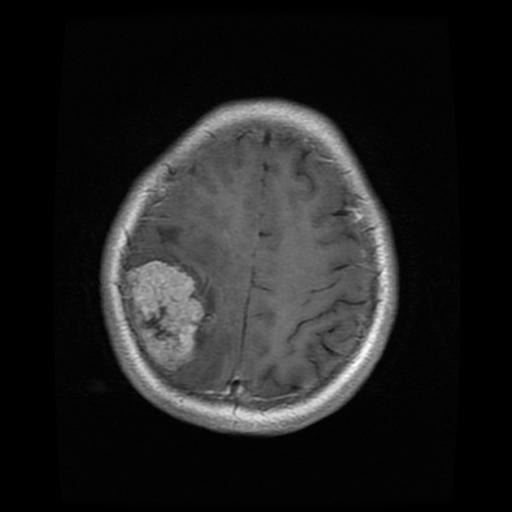

In [5]:
sample_image = Image.open('/content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/meningioma/Tr-me_0011.jpg')
sample_image

In [6]:
sample_image.size

(512, 512)

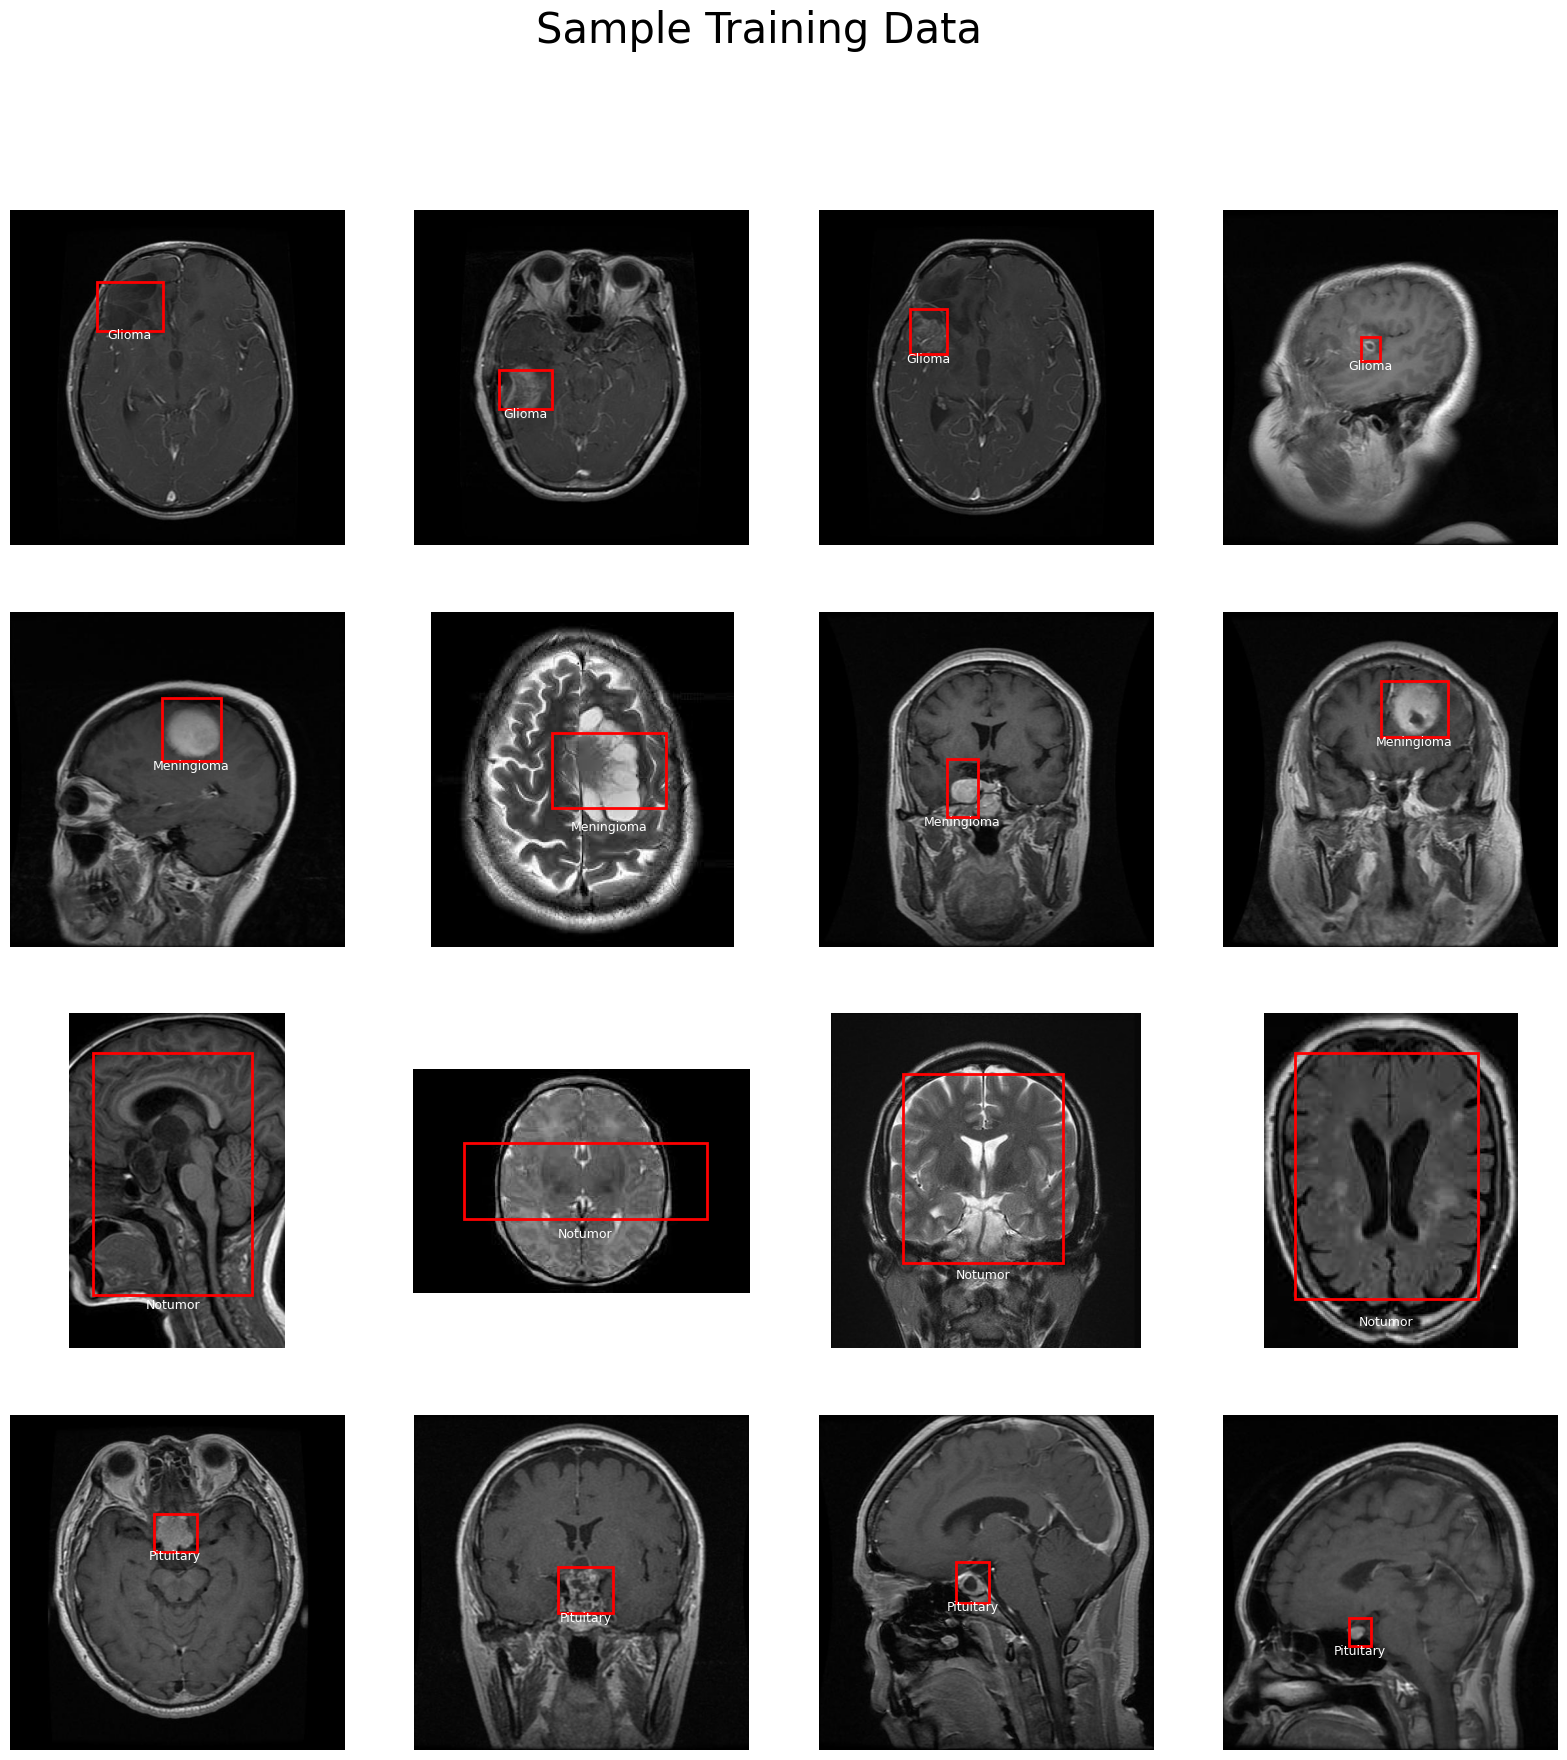

In [7]:
# Plotting the training data with bounding boxes
dataset_directory = '/content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/'
class_labels = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

fig, axes = plt.subplots(4, 4, figsize=(20, 20))

for class_name, ax_row in zip(class_labels.keys(), axes):
    class_directory = os.path.join(dataset_directory, class_name)
    image_files = [f for f in os.listdir(class_directory) if f.endswith('.jpg')]
    selected_images = random.sample(image_files, 4)

    for ax, image_file in zip(ax_row, selected_images):
        annotation_file = os.path.join(class_directory, image_file.replace('.jpg', '.txt'))
        with open(annotation_file, 'r') as file:
            line = file.readline().strip().split()
            class_number, centre_x, centre_y, height, width = map(float, line)

        img = plt.imread(os.path.join(class_directory, image_file))

        if len(img.shape) == 2:
            img = np.stack((img,) * 3, axis=-1)

        img_height, img_width, _ = img.shape
        x_min = (centre_x - width / 2) * img_width
        y_min = (centre_y - height / 2) * img_height
        x_max = (centre_x + width / 2) * img_width
        y_max = (centre_y + height / 2) * img_height
        tumor_bbox = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none', label=f'{class_name.capitalize()}')
        ax.imshow(img)
        ax.add_patch(tumor_bbox)

        label_text = f'{class_name.capitalize()}'
        ax.text((x_min + x_max) / 2, y_max + 18, label_text, color='w', ha='center', va='bottom', fontsize=9)

for ax_row in axes:
    for ax in ax_row:
        ax.axis('off')

plt.suptitle("Sample Training Data", fontsize=30)
plt.show()

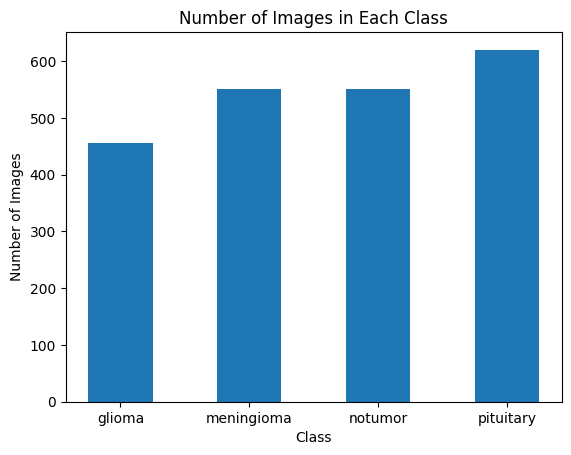

In [8]:
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
class_counts = [456, 551, 550, 620]

plt.bar(class_names, class_counts, width=0.5)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.show()

# **Train-Test Split**

In [9]:
def custom_train_test_split(dataset_directory, test_ratio=0.2, random_seed=None, min_samples_per_class=2):
    """
    Custom function to perform a stratified train-test split on an image dataset.
    This function organizes the dataset into 'train' and 'test' directories while maintaining the class-wise distribution.
    It creates the 'train' and 'test' directories within the given dataset directory and moves images accordingly.
    """
    random_seed = random_seed or 42

    class_directories = [d for d in os.listdir(dataset_directory) if os.path.isdir(os.path.join(dataset_directory, d))]

    train_directory = os.path.join(dataset_directory, 'train')
    test_directory = os.path.join(dataset_directory, 'test')
    os.makedirs(train_directory, exist_ok=True)
    os.makedirs(test_directory, exist_ok=True)

    for class_dir in class_directories:
        class_path = os.path.join(dataset_directory, class_dir)

        image_files = [f for f in os.listdir(class_path) if f.endswith('.jpg')]

        if len(image_files) < min_samples_per_class:
            continue

        train_images, test_images = train_test_split(image_files, test_size=test_ratio, random_state=random_seed)

        for train_image in train_images:
            src_image_path = os.path.join(class_path, train_image)
            src_annotation_path = os.path.join(class_path, train_image.replace('.jpg', '.txt'))

            dest_image_path = os.path.join(train_directory, class_dir, train_image)
            dest_annotation_path = os.path.join(train_directory, class_dir, train_image.replace('.jpg', '.txt'))

            os.makedirs(os.path.dirname(dest_image_path), exist_ok=True)

            if os.path.exists(src_annotation_path):
                shutil.move(src_image_path, dest_image_path)
                shutil.move(src_annotation_path, dest_annotation_path)

        for test_image in test_images:
            src_image_path = os.path.join(class_path, test_image)
            src_annotation_path = os.path.join(class_path, test_image.replace('.jpg', '.txt'))

            dest_image_path = os.path.join(test_directory, class_dir, test_image)
            dest_annotation_path = os.path.join(test_directory, class_dir, test_image.replace('.jpg', '.txt'))

            os.makedirs(os.path.dirname(dest_image_path), exist_ok=True)

            if os.path.exists(src_annotation_path):
                shutil.move(src_image_path, dest_image_path)
                shutil.move(src_annotation_path, dest_annotation_path)

In [10]:
dataset_directory = '/content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/'
custom_train_test_split(dataset_directory, test_ratio=0.2, random_seed=42, min_samples_per_class=2)

In [11]:
def count_images_per_class(directory):
    class_counts = {}
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):
            class_counts[class_dir] = len([f for f in os.listdir(class_path) if f.endswith('.jpg')])
    return class_counts

In [12]:
def plot_image_counts(train_directory, test_directory):
    """
    Plot the number of images in each class for both the training and testing sets.
    This function counts the number of images in each class for both the training and testing sets
    and plots a bar chart to visualize the distribution.
    """
    train_counts = count_images_per_class(train_directory)
    test_counts = count_images_per_class(test_directory)

    class_names = list(train_counts.keys())
    train_counts_values = list(train_counts.values())
    test_counts_values = [test_counts[class_name] for class_name in class_names]

    bar_width = 0.35
    index = range(len(class_names))

    fig, ax = plt.subplots()
    bar1 = ax.bar(index, train_counts_values, bar_width, label='Train')
    bar2 = ax.bar([i + bar_width for i in index], test_counts_values, bar_width, label='Test')

    ax.set_xlabel('Class')
    ax.set_ylabel('Number of Images')
    ax.set_title('Number of Images in Each Class for Train and Test Sets')
    ax.set_xticks([i + bar_width/2 for i in index])
    ax.set_xticklabels(class_names)
    ax.legend()

    plt.show()

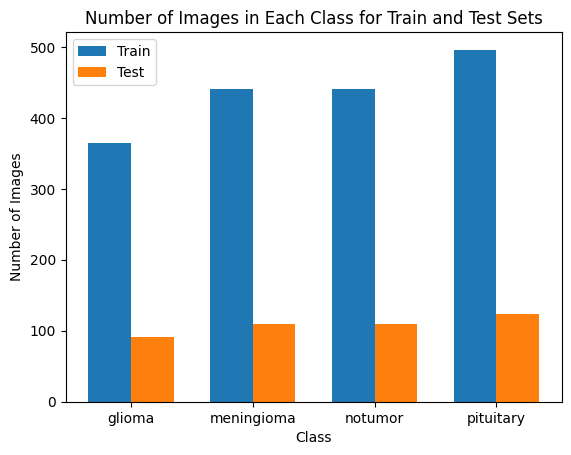

In [13]:
dataset_directory = '/content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/'
train_directory = os.path.join(dataset_directory, 'train')
test_directory = os.path.join(dataset_directory, 'test')

plot_image_counts(train_directory, test_directory)

# **YOLOv8n**

### **Modelling**

In [14]:
yolo_btd_model = YOLO('yolov8n.yaml')

yolo_btd_model_results = yolo_btd_model.train(data='/content/drive/MyDrive/brain_tumor_object_detection/brain_tumor_dataset.yaml', epochs=25)

Ultralytics 8.3.1 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/drive/MyDrive/brain_tumor_object_detection/brain_tumor_dataset.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=

100%|██████████| 755k/755k [00:00<00:00, 72.1MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 301MB/s]

WARNING ⚠️ yolo11n.pt appears to require 'dill', which is not in Ultralytics requirements.
AutoInstall will run now for 'dill' but this feature will be removed in the future.
Recommend fixes are to train a new model using the latest 'ultralytics' package or to run a command with an official Ultralytics model, i.e. 'yolo predict model=yolov8n.pt'
requirements: Ultralytics requirement ['dill'] not found, attempting AutoUpdate...


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 49.0 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 2.4s, installed 1 package: ['dill']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

AMP: checks failed ❌. Anomalies were detected with AMP on your system that may lead to NaN losses or zero-mAP results, so AMP will be disabled during training.


train: Scanning /content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/train/glioma... 1740 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1740/1740 [00:20<00:00, 85.61it/s]


train: New cache created: /content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/train/glioma.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.16 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/test/glioma... 435 images, 0 backgrounds, 0 corrupt: 100%|██████████| 435/435 [00:05<00:00, 80.24it/s] 


val: New cache created: /content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/test/glioma.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 63 weight(decay=0.0), 70 weight(decay=0.0005), 69 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      4.27G      3.422      5.178        4.1         22        640: 100%|██████████| 109/109 [00:49<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.71it/s]

                   all        435        439   0.000718      0.211      0.011    0.00277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      4.23G      2.913      4.302      3.305         15        640: 100%|██████████| 109/109 [00:47<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:07<00:00,  1.99it/s]

                   all        435        439      0.321     0.0835     0.0492     0.0169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      4.28G      2.607       3.47      2.867         24        640: 100%|██████████| 109/109 [00:45<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.68it/s]

                   all        435        439      0.432      0.377      0.327      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      4.23G      2.329      2.796       2.63         13        640: 100%|██████████| 109/109 [00:44<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.75it/s]


                   all        435        439      0.553      0.437      0.484      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      4.28G      2.185      2.401      2.476         26        640: 100%|██████████| 109/109 [00:45<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.58it/s]


                   all        435        439      0.635      0.444       0.53      0.255

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      4.22G      2.071      2.127      2.373         22        640: 100%|██████████| 109/109 [00:47<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.64it/s]

                   all        435        439      0.661      0.581      0.635       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      4.22G      1.984      2.004      2.272         19        640: 100%|██████████| 109/109 [00:48<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.70it/s]

                   all        435        439      0.637      0.527      0.638      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      4.22G      1.884      1.853      2.213         16        640: 100%|██████████| 109/109 [00:48<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.66it/s]


                   all        435        439      0.644      0.674       0.69      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      4.28G      1.855      1.756      2.162         28        640: 100%|██████████| 109/109 [00:46<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:07<00:00,  1.95it/s]

                   all        435        439       0.71      0.626      0.687      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      4.22G      1.779      1.669      2.101         22        640: 100%|██████████| 109/109 [00:44<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:09<00:00,  1.55it/s]

                   all        435        439      0.681      0.666      0.733      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      4.22G      1.719      1.571      2.044         23        640: 100%|██████████| 109/109 [00:44<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.19it/s]

                   all        435        439      0.739      0.682      0.751      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      4.22G      1.716      1.526      2.046         26        640: 100%|██████████| 109/109 [00:44<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.64it/s]

                   all        435        439      0.713      0.683      0.766      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      4.28G       1.68      1.459      2.004         14        640: 100%|██████████| 109/109 [00:45<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.31it/s]

                   all        435        439      0.736      0.701      0.758      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      4.22G      1.647      1.392      1.975         25        640: 100%|██████████| 109/109 [00:43<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:07<00:00,  1.76it/s]

                   all        435        439      0.748      0.734      0.787       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      4.22G      1.616      1.394      1.931         27        640: 100%|██████████| 109/109 [00:43<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.74it/s]

                   all        435        439      0.833      0.695      0.801      0.455


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      4.22G       1.59      1.324      2.046         12        640: 100%|██████████| 109/109 [00:45<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.74it/s]

                   all        435        439      0.796      0.767      0.818      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      4.22G      1.548      1.236      2.011         12        640: 100%|██████████| 109/109 [00:44<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.44it/s]

                   all        435        439       0.81      0.733      0.814      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      4.22G      1.519      1.177       1.99         12        640: 100%|██████████| 109/109 [00:41<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:07<00:00,  1.78it/s]

                   all        435        439      0.804      0.781      0.843      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      4.22G      1.496      1.116      1.955         14        640: 100%|██████████| 109/109 [00:41<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.76it/s]

                   all        435        439      0.809      0.752      0.833       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      4.22G      1.474      1.102      1.944         12        640: 100%|██████████| 109/109 [00:44<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.21it/s]

                   all        435        439        0.8      0.791      0.862      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      4.22G      1.446      1.047      1.904         13        640: 100%|██████████| 109/109 [00:41<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:07<00:00,  1.96it/s]

                   all        435        439      0.837      0.784      0.861      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      4.22G      1.434      1.023      1.906         13        640: 100%|██████████| 109/109 [00:42<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.66it/s]

                   all        435        439      0.827       0.81      0.869      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      4.22G      1.419      1.006       1.88         12        640: 100%|██████████| 109/109 [00:47<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.65it/s]

                   all        435        439      0.859      0.793      0.869      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      4.22G      1.396     0.9588      1.878         14        640: 100%|██████████| 109/109 [00:42<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:09<00:00,  1.54it/s]

                   all        435        439      0.876      0.803      0.875      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      4.22G      1.381     0.9628      1.855         12        640: 100%|██████████| 109/109 [00:41<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.79it/s]

                   all        435        439      0.869      0.813      0.878      0.514



25 epochs completed in 0.367 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.1 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 186 layers, 2,685,148 parameters, 0 gradients, 6.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.60it/s]


                   all        435        439      0.869      0.813      0.878      0.514
                glioma        124        125      0.904      0.905      0.941      0.469
            meningioma        110        110      0.915      0.877      0.949      0.572
               notumor         91         94      0.766      0.543      0.651      0.298
             pituitary        110        110      0.891      0.927      0.972      0.718
Speed: 0.3ms preprocess, 3.8ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/detect/train


In [15]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [16]:
cp -r runs /content/drive/MyDrive/brain_tumor_object_detection

## **Performance Metrics**

In [17]:
def plot_images(image_paths):
    fig, axes = plt.subplots(len(image_paths), 1, figsize=(80, 80))

    for i, ax in enumerate(axes):
        image_path = image_paths[i]
        img = mpimg.imread(image_path)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(os.path.basename(image_path))

    plt.tight_layout()
    plt.show()

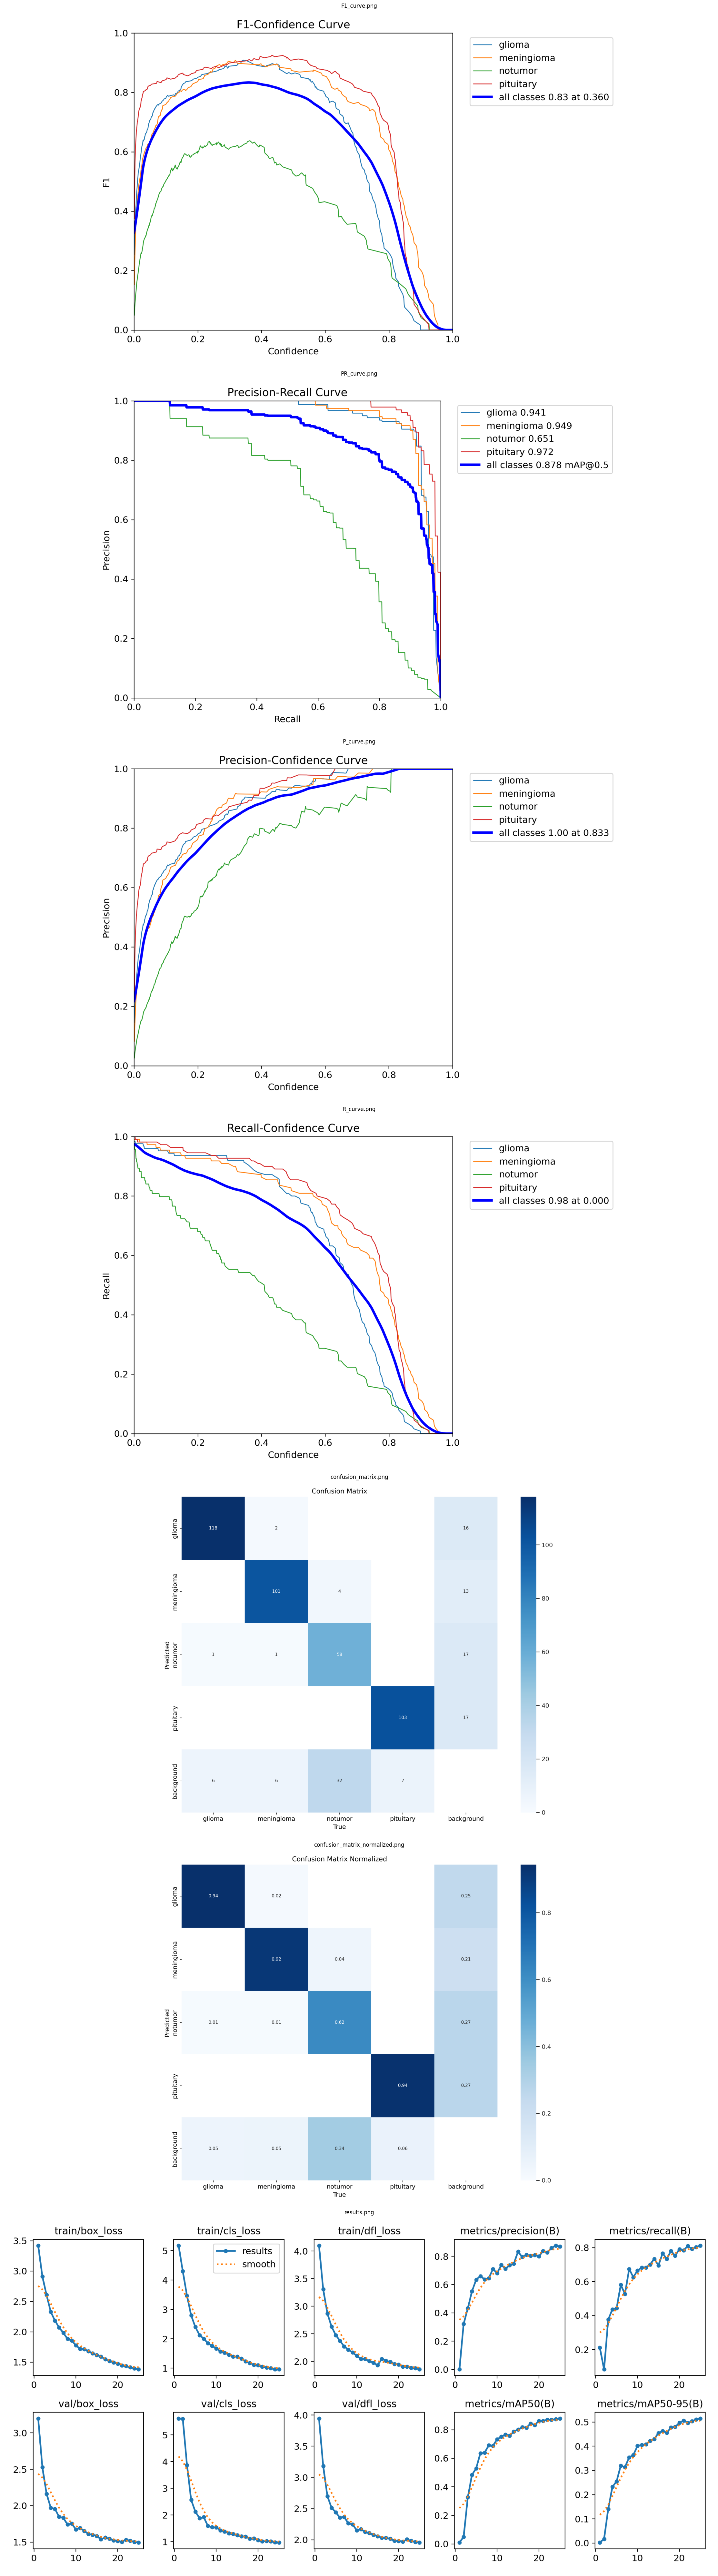

In [18]:
image_paths = [
    '/content/drive/MyDrive/brain_tumor_object_detection/runs/detect/train/F1_curve.png',
    '/content/drive/MyDrive/brain_tumor_object_detection/runs/detect/train/PR_curve.png',
    '/content/drive/MyDrive/brain_tumor_object_detection/runs/detect/train/P_curve.png',
    '/content/drive/MyDrive/brain_tumor_object_detection/runs/detect/train/R_curve.png',
    '/content/drive/MyDrive/brain_tumor_object_detection/runs/detect/train/confusion_matrix.png',
    '/content/drive/MyDrive/brain_tumor_object_detection/runs/detect/train/confusion_matrix_normalized.png',
    '/content/drive/MyDrive/brain_tumor_object_detection/runs/detect/train/results.png',
]
plot_images(image_paths)

## **Testing**

In [19]:
def predict_results(test_images_dir):
    # output_dir= "/content/drive/MyDrive/Sample"
    model = YOLO('/content/drive/MyDrive/brain_tumor_object_detection/runs/detect/train/weights/best.pt')
    # os.makedirs(output_dir, exist_ok=True)

    image_files = [f for f in os.listdir(test_images_dir) if f.lower().endswith('.jpg')]


    for image_file in image_files:
        image_path = os.path.join(test_images_dir, image_file)
        model.predict(image_path, save=True, imgsz=320, conf=0.3)

In [20]:
glioma_test_dir = '/content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/test/glioma'
predict_results(glioma_test_dir)


image 1/1 /content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/test/glioma/Tr-gl_0011.jpg: 320x320 (no detections), 8.5ms
Speed: 1.8ms preprocess, 8.5ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 320)
Results saved to runs/detect/predict

image 1/1 /content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/test/glioma/Tr-gl_0022.jpg: 320x320 2 notumors, 16.0ms
Speed: 1.3ms preprocess, 16.0ms inference, 2.6ms postprocess per image at shape (1, 3, 320, 320)
Results saved to runs/detect/predict

image 1/1 /content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/test/glioma/Tr-gl_0025.jpg: 320x320 (no detections), 9.3ms
Speed: 1.0ms preprocess, 9.3ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 320)
Results saved to runs/detect/predict

image 1/1 /content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/test/glioma/Tr-gl_0029.jpg: 320x320 2 notum

In [21]:
meningioma_test_dir = '/content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/test/meningioma'
predict_results(meningioma_test_dir)


image 1/1 /content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/test/meningioma/Tr-me_0010.jpg: 320x320 1 meningioma, 9.8ms
Speed: 1.7ms preprocess, 9.8ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 320)
Results saved to runs/detect/predict2

image 1/1 /content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/test/meningioma/Tr-me_0012.jpg: 320x320 (no detections), 6.8ms
Speed: 0.9ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 320)
Results saved to runs/detect/predict2

image 1/1 /content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/test/meningioma/Tr-me_0016.jpg: 320x320 1 meningioma, 1 notumor, 22.2ms
Speed: 2.4ms preprocess, 22.2ms inference, 2.2ms postprocess per image at shape (1, 3, 320, 320)
Results saved to runs/detect/predict2

image 1/1 /content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/test/meningioma/Tr

In [22]:
notumor_test_dir = '/content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/test/notumor'
predict_results(notumor_test_dir)


image 1/1 /content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/test/notumor/Tr-no_0010.jpg: 320x320 1 pituitary, 9.1ms
Speed: 1.2ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 320)
Results saved to runs/detect/predict3

image 1/1 /content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/test/notumor/Tr-no_0012.jpg: 320x320 1 pituitary, 6.6ms
Speed: 1.0ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 320)
Results saved to runs/detect/predict3

image 1/1 /content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/test/notumor/Tr-no_0016.jpg: 320x320 1 pituitary, 30.8ms
Speed: 1.6ms preprocess, 30.8ms inference, 5.7ms postprocess per image at shape (1, 3, 320, 320)
Results saved to runs/detect/predict3

image 1/1 /content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/test/notumor/Tr-no_0019.jpg: 320x320 1 pitui

In [23]:
pituitary_test_dir = '/content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/test/pituitary'
predict_results(pituitary_test_dir)


image 1/1 /content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/test/pituitary/Tr-pi_0012.jpg: 320x320 1 glioma, 8.1ms
Speed: 1.3ms preprocess, 8.1ms inference, 2.4ms postprocess per image at shape (1, 3, 320, 320)
Results saved to runs/detect/predict4

image 1/1 /content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/test/pituitary/Tr-pi_0016.jpg: 320x320 1 glioma, 6.7ms
Speed: 0.9ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 320)
Results saved to runs/detect/predict4

image 1/1 /content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/test/pituitary/Tr-pi_0020.jpg: 320x320 1 glioma, 35.9ms
Speed: 1.7ms preprocess, 35.9ms inference, 4.8ms postprocess per image at shape (1, 3, 320, 320)
Results saved to runs/detect/predict4

image 1/1 /content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/test/pituitary/Tr-pi_0037.jpg: 320x256 1 glioma

In [25]:
!rm -r /content/drive/MyDrive/brain_tumor_object_detection/runs

In [26]:
cp -r runs /content/drive/MyDrive/brain_tumor_object_detection

In [27]:
cp -r sample_data /content/drive/MyDrive/brain_tumor_object_detection

In [28]:
cp yolo11n.pt /content/drive/MyDrive/brain_tumor_object_detection